# Introduction and Setup

This notebook utilizes a CycleGAN architecture to add Monet-style to photos. For this tutorial, we will be using the TFRecord dataset. Import the following packages and configure for GPU.

For more information, check out [TensorFlow](https://www.tensorflow.org/tutorials/generative/cyclegan) and [Keras](https://keras.io/examples/generative/cyclegan/) CycleGAN documentation pages.

In [1]:
from os import path, makedirs, environ
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

if 'KAGGLE_URL_BASE' in environ:
    from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

# Configure GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Using GPU: {gpus[0]}")
        strategy = tf.distribute.MirroredStrategy()
    except RuntimeError as e:
        print(e)
else:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

2025-09-11 06:13:28.602803: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
2.20.0


I0000 00:00:1757560412.458951  199688 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4459 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


# Load in the data

We want to keep our photo dataset and our Monet dataset separate. First, load in the filenames of the TFRecords.

In [2]:
GCS_PATH = KaggleDatasets().get_gcs_path() if 'KAGGLE_URL_BASE' in environ else "data"
IMG_PATH =  "../tmp" if 'KAGGLE_URL_BASE' in environ else "tmp"
ZIP_NAME = "/kaggle/working/images" if 'KAGGLE_URL_BASE' in environ else "images"
makedirs(IMG_PATH, exist_ok=True)

In [3]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.

In [4]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

Define the function to extract the image from the files.

In [5]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

Let's load in our datasets.

In [6]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [7]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

2025-09-11 06:13:32.640933: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:390] TFRecordDataset `buffer_size` is unspecified, default to 262144


Let's  visualize a photo example and a Monet example.

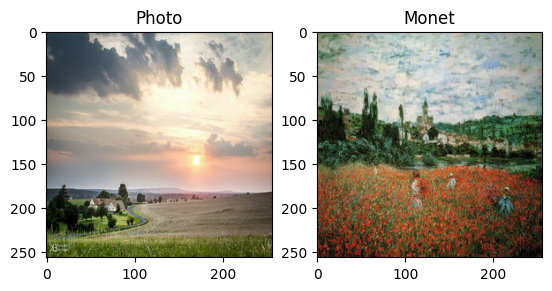

In [8]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

# Build the generator

We'll be using a UNET architecture for our CycleGAN. To build our generator, let's first define our `downsample` and `upsample` methods.

The `downsample`, as the name suggests, reduces the 2D dimensions, the width and height, of the image by the stride. The stride is the length of the step the filter takes. Since the stride is 2, the filter is applied to every other pixel, hence reducing the weight and height by 2.

We'll be using LayerNormalization instead of instance normalization.

In [9]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_normalization=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_normalization:
        result.add(layers.LayerNormalization(epsilon=1e-5))

    result.add(layers.LeakyReLU())

    return result

`Upsample` does the opposite of downsample and increases the dimensions of the of the image. `Conv2DTranspose` does basically the opposite of a `Conv2D` layer.

In [10]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(layers.LayerNormalization(epsilon=1e-5))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

Let's build our generator!

The generator first downsamples the input image and then upsample while establishing long skip connections. Skip connections are a way to help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of only one. Here we concatenate the output of the downsample layer to the upsample layer in a symmetrical fashion.

In [11]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_normalization=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

# Build the discriminator

The discriminator takes in the input image and classifies it as real or fake (generated). Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

In [12]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = layers.LayerNormalization(epsilon=1e-5)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [13]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

Since our generators are not trained yet, the generated Monet-esque photo does not show what is expected at this point.

2025-09-11 06:13:33.493174: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
2025-09-11 06:13:34.602615: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.31GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-09-11 06:13:34.697390: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-09-11 06:13:34.715134: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that t

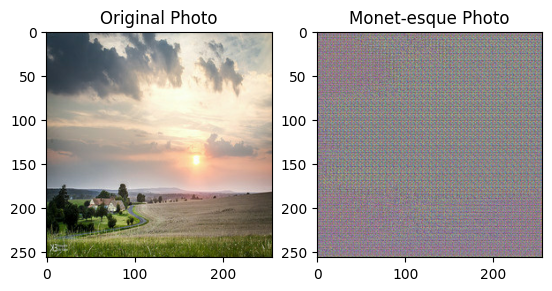

In [14]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

# Build the CycleGAN model

We will subclass a `tf.keras.Model` so that we can run `fit()` later to train our model. During the training step, the model transforms a photo to a Monet painting and then back to a photo. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss. We want the original photo and the twice-transformed photo to be similar to one another.

The losses are defined in the next section.

In [15]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def call(self, inputs, training=False):
        # For inference, return the monet generator output
        return self.m_gen(inputs, training=training)

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# Define loss functions

The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.

In [16]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s. Thus, it compares the generated image to a matrix of 1s to find the loss.

In [17]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

We want our original photo and the twice transformed photo to be similar to one another. Thus, we can calculate the cycle consistency loss be finding the average of their difference.

In [18]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

The identity loss compares the image with its generator (i.e. photo with photo generator). If given a photo as input, we want it to generate the same image as the image was originally a photo. The identity loss compares the input with the output of the generator.

In [19]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# Train the CycleGAN

Let's compile our model. Since we used `tf.keras.Model` to build our CycleGAN, we can just ude the `fit` function to train our model.

In [20]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [21]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [22]:
# Build the model by calling it with a sample input
sample_input = tf.random.normal([1, 256, 256, 3])
_ = cycle_gan_model(sample_input, training=False)

cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 1/25


E0000 00:00:1757560442.302995  199688 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_31_5/sequential_23_1/dropout_3_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-11 06:14:07.086544: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-09-11 06:14:08.254761: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-09-11 06:14:08.254801: W external/local_xla/xla/tsl/framework/bfc_al

    299/Unknown 208s 580ms/step - monet_disc_loss: 0.7399 - monet_gen_loss: 6.3255 - photo_disc_loss: 0.7314 - photo_gen_loss: 6.5064

2025-09-11 06:17:03.158934: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-09-11 06:17:03.159026: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


    300/Unknown 208s 580ms/step - monet_disc_loss: 0.7403 - monet_gen_loss: 6.3172 - photo_disc_loss: 0.7319 - photo_gen_loss: 6.4985INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
300/300 ━━━━━━━━━━━━━━━━━━━━ 208s 580ms/step - monet_disc_loss: 0.8804 - monet_gen_loss: 3.8217 - photo_disc_loss: 0.8831 - photo_gen_loss: 4.1420
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 2/25


2025-09-11 06:17:03.768393: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 7535934048272470096
2025-09-11 06:17:03.768430: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 798534235572574422
2025-09-11 06:17:03.768440: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 2303870818829296946
2025-09-11 06:17:03.768449: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 2741883699155390026
2025-09-11 06:17:03.768458: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 7265020498782081119
2025-09-11 06:17:03.768468: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 8068167926720752379
2025-09-11 06:17:03.768477: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item

299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - monet_disc_loss: 0.6533 - monet_gen_loss: 4.2325 - photo_disc_loss: 0.6691 - photo_gen_loss: 4.2179

2025-09-11 06:20:33.698358: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - monet_disc_loss: 0.6538 - monet_gen_loss: 4.2276 - photo_disc_loss: 0.6696 - photo_gen_loss: 4.2140INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
300/300 ━━━━━━━━━━━━━━━━━━━━ 211s 702ms/step - monet_disc_loss: 0.8202 - monet_gen_loss: 2.7672 - photo_disc_loss: 0.8221 - photo_gen_loss: 3.0559
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 3/25


2025-09-11 06:20:34.441811: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 7535934048272470096
2025-09-11 06:20:34.441847: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 8068167926720752379
2025-09-11 06:20:34.441857: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 728402825295637383


299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - monet_disc_loss: 0.6426 - monet_gen_loss: 3.6599 - photo_disc_loss: 0.6645 - photo_gen_loss: 3.6136

2025-09-11 06:25:21.416463: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 289s 962ms/step - monet_disc_loss: 0.8434 - monet_gen_loss: 2.1094 - photo_disc_loss: 0.8181 - photo_gen_loss: 2.4936
Epoch 4/25


2025-09-11 06:25:23.201847: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 7535934048272470096
2025-09-11 06:25:23.201884: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 8068167926720752379
2025-09-11 06:25:23.201892: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 728402825295637383


300/300 ━━━━━━━━━━━━━━━━━━━━ 327s 1s/step - monet_disc_loss: 0.7726 - monet_gen_loss: 1.9274 - photo_disc_loss: 0.8266 - photo_gen_loss: 2.2515
Epoch 5/25


2025-09-11 06:30:49.787735: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 7535934048272470096
2025-09-11 06:30:49.787773: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 8068167926720752379
2025-09-11 06:30:49.787781: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 728402825295637383


300/300 ━━━━━━━━━━━━━━━━━━━━ 299s 998ms/step - monet_disc_loss: 0.8011 - monet_gen_loss: 1.8017 - photo_disc_loss: 0.8397 - photo_gen_loss: 2.1723
Epoch 6/25


2025-09-11 06:35:48.962252: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 7535934048272470096
2025-09-11 06:35:48.962284: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 8068167926720752379
2025-09-11 06:35:48.962293: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 728402825295637383


299/300 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - monet_disc_loss: 0.6363 - monet_gen_loss: 3.0963 - photo_disc_loss: 0.6565 - photo_gen_loss: 3.0600

2025-09-11 06:40:53.277951: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 305s 1s/step - monet_disc_loss: 0.8508 - monet_gen_loss: 1.7272 - photo_disc_loss: 0.8352 - photo_gen_loss: 2.1781
Epoch 7/25


2025-09-11 06:40:54.212569: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 7535934048272470096
2025-09-11 06:40:54.212589: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 8068167926720752379
2025-09-11 06:40:54.212593: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 728402825295637383


300/300 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - monet_disc_loss: 0.9269 - monet_gen_loss: 1.6535 - photo_disc_loss: 0.8187 - photo_gen_loss: 2.1384
Epoch 8/25


2025-09-11 06:46:15.469354: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 7535934048272470096
2025-09-11 06:46:15.469379: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 8068167926720752379
2025-09-11 06:46:15.469383: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 728402825295637383


300/300 ━━━━━━━━━━━━━━━━━━━━ 305s 1s/step - monet_disc_loss: 0.8629 - monet_gen_loss: 1.6972 - photo_disc_loss: 0.7992 - photo_gen_loss: 2.1840
Epoch 9/25


2025-09-11 06:51:20.524755: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 7535934048272470096
2025-09-11 06:51:20.524790: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 8068167926720752379
2025-09-11 06:51:20.524799: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 728402825295637383


300/300 ━━━━━━━━━━━━━━━━━━━━ 337s 1s/step - monet_disc_loss: 0.8365 - monet_gen_loss: 1.6160 - photo_disc_loss: 0.7921 - photo_gen_loss: 2.1208
Epoch 10/25


2025-09-11 06:56:57.189392: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 7535934048272470096
2025-09-11 06:56:57.189412: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 8068167926720752379
2025-09-11 06:56:57.189415: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 728402825295637383


300/300 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - monet_disc_loss: 0.8299 - monet_gen_loss: 1.6809 - photo_disc_loss: 0.8120 - photo_gen_loss: 2.0804
Epoch 11/25


2025-09-11 07:02:51.716170: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 7535934048272470096
2025-09-11 07:02:51.716191: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 8068167926720752379
2025-09-11 07:02:51.716196: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 728402825295637383


299/300 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - monet_disc_loss: 0.6296 - monet_gen_loss: 2.7603 - photo_disc_loss: 0.6493 - photo_gen_loss: 2.7227

2025-09-11 07:08:59.207489: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 369s 1s/step - monet_disc_loss: 0.9065 - monet_gen_loss: 1.6205 - photo_disc_loss: 0.8108 - photo_gen_loss: 2.0586
Epoch 12/25


2025-09-11 07:09:01.143376: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 7535934048272470096
2025-09-11 07:09:01.143410: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 8068167926720752379
2025-09-11 07:09:01.143418: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 728402825295637383


300/300 ━━━━━━━━━━━━━━━━━━━━ 375s 1s/step - monet_disc_loss: 0.8298 - monet_gen_loss: 1.5131 - photo_disc_loss: 0.8165 - photo_gen_loss: 1.9531
Epoch 13/25


2025-09-11 07:15:16.561050: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 7535934048272470096
2025-09-11 07:15:16.561075: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 8068167926720752379
2025-09-11 07:15:16.561078: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 728402825295637383


300/300 ━━━━━━━━━━━━━━━━━━━━ 383s 1s/step - monet_disc_loss: 0.3994 - monet_gen_loss: 2.3917 - photo_disc_loss: 0.8306 - photo_gen_loss: 1.9779
Epoch 14/25


2025-09-11 07:21:40.024613: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 7535934048272470096
2025-09-11 07:21:40.024639: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 8068167926720752379
2025-09-11 07:21:40.024645: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 728402825295637383


300/300 ━━━━━━━━━━━━━━━━━━━━ 431s 1s/step - monet_disc_loss: 0.7583 - monet_gen_loss: 1.5932 - photo_disc_loss: 0.8560 - photo_gen_loss: 1.9054
Epoch 15/25


2025-09-11 07:28:51.444775: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 7535934048272470096
2025-09-11 07:28:51.444795: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 8068167926720752379
2025-09-11 07:28:51.444799: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 728402825295637383


300/300 ━━━━━━━━━━━━━━━━━━━━ 474s 2s/step - monet_disc_loss: 0.6540 - monet_gen_loss: 1.6425 - photo_disc_loss: 0.8349 - photo_gen_loss: 1.8895
Epoch 16/25


2025-09-11 07:36:45.458798: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 7535934048272470096
2025-09-11 07:36:45.458818: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 8068167926720752379
2025-09-11 07:36:45.458823: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 728402825295637383


300/300 ━━━━━━━━━━━━━━━━━━━━ 452s 2s/step - monet_disc_loss: 0.6615 - monet_gen_loss: 1.7284 - photo_disc_loss: 0.8468 - photo_gen_loss: 1.8544
Epoch 17/25


2025-09-11 07:44:17.416657: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 7535934048272470096
2025-09-11 07:44:17.416741: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 8068167926720752379
2025-09-11 07:44:17.416749: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 728402825295637383


300/300 ━━━━━━━━━━━━━━━━━━━━ 415s 1s/step - monet_disc_loss: 0.2522 - monet_gen_loss: 2.6017 - photo_disc_loss: 0.8393 - photo_gen_loss: 1.8903
Epoch 18/25


2025-09-11 07:51:12.276607: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 7535934048272470096
2025-09-11 07:51:12.276641: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 8068167926720752379
2025-09-11 07:51:12.276650: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 728402825295637383


300/300 ━━━━━━━━━━━━━━━━━━━━ 491s 2s/step - monet_disc_loss: 0.5160 - monet_gen_loss: 1.6737 - photo_disc_loss: 0.8313 - photo_gen_loss: 1.8700
Epoch 19/25


2025-09-11 07:59:23.346953: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 7535934048272470096
2025-09-11 07:59:23.346987: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 8068167926720752379
2025-09-11 07:59:23.346995: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 728402825295637383


300/300 ━━━━━━━━━━━━━━━━━━━━ 580s 2s/step - monet_disc_loss: 1.0226 - monet_gen_loss: 1.2573 - photo_disc_loss: 0.8576 - photo_gen_loss: 1.8673
Epoch 20/25


2025-09-11 08:09:03.766380: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 7535934048272470096
2025-09-11 08:09:03.766409: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 8068167926720752379
2025-09-11 08:09:03.766416: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 728402825295637383


300/300 ━━━━━━━━━━━━━━━━━━━━ 465s 2s/step - monet_disc_loss: 0.9287 - monet_gen_loss: 1.4072 - photo_disc_loss: 0.8430 - photo_gen_loss: 1.9631
Epoch 21/25


2025-09-11 08:16:48.445360: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 7535934048272470096
2025-09-11 08:16:48.445387: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 8068167926720752379
2025-09-11 08:16:48.445394: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 728402825295637383


300/300 ━━━━━━━━━━━━━━━━━━━━ 401s 1s/step - monet_disc_loss: 0.4415 - monet_gen_loss: 1.8935 - photo_disc_loss: 0.8052 - photo_gen_loss: 2.0029
Epoch 22/25


2025-09-11 08:23:29.796892: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 7535934048272470096
2025-09-11 08:23:29.796925: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 8068167926720752379
2025-09-11 08:23:29.796933: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 728402825295637383


299/300 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - monet_disc_loss: 0.4360 - monet_gen_loss: 3.2907 - photo_disc_loss: 0.6214 - photo_gen_loss: 2.5193

2025-09-11 08:30:13.210378: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 405s 1s/step - monet_disc_loss: 1.4848 - monet_gen_loss: 1.1282 - photo_disc_loss: 0.8533 - photo_gen_loss: 1.8197
Epoch 23/25


2025-09-11 08:30:14.329435: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 7535934048272470096
2025-09-11 08:30:14.329455: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 8068167926720752379
2025-09-11 08:30:14.329459: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 728402825295637383


300/300 ━━━━━━━━━━━━━━━━━━━━ 507s 2s/step - monet_disc_loss: 0.8875 - monet_gen_loss: 1.4136 - photo_disc_loss: 0.7921 - photo_gen_loss: 1.9283
Epoch 24/25


2025-09-11 08:38:40.943986: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 7535934048272470096
2025-09-11 08:38:40.944016: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 8068167926720752379
2025-09-11 08:38:40.944023: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 728402825295637383


300/300 ━━━━━━━━━━━━━━━━━━━━ 513s 2s/step - monet_disc_loss: 1.2041 - monet_gen_loss: 1.3848 - photo_disc_loss: 0.8786 - photo_gen_loss: 1.9590
Epoch 25/25


2025-09-11 08:47:14.340616: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 7535934048272470096
2025-09-11 08:47:14.340642: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 8068167926720752379
2025-09-11 08:47:14.340649: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 728402825295637383


300/300 ━━━━━━━━━━━━━━━━━━━━ 552s 2s/step - monet_disc_loss: 0.7199 - monet_gen_loss: 1.6373 - photo_disc_loss: 0.8365 - photo_gen_loss: 1.9373


2025-09-11 08:56:25.955001: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 7535934048272470096
2025-09-11 08:56:25.955028: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 8068167926720752379
2025-09-11 08:56:25.955032: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 728402825295637383


# Visualize our Monet-esque photos

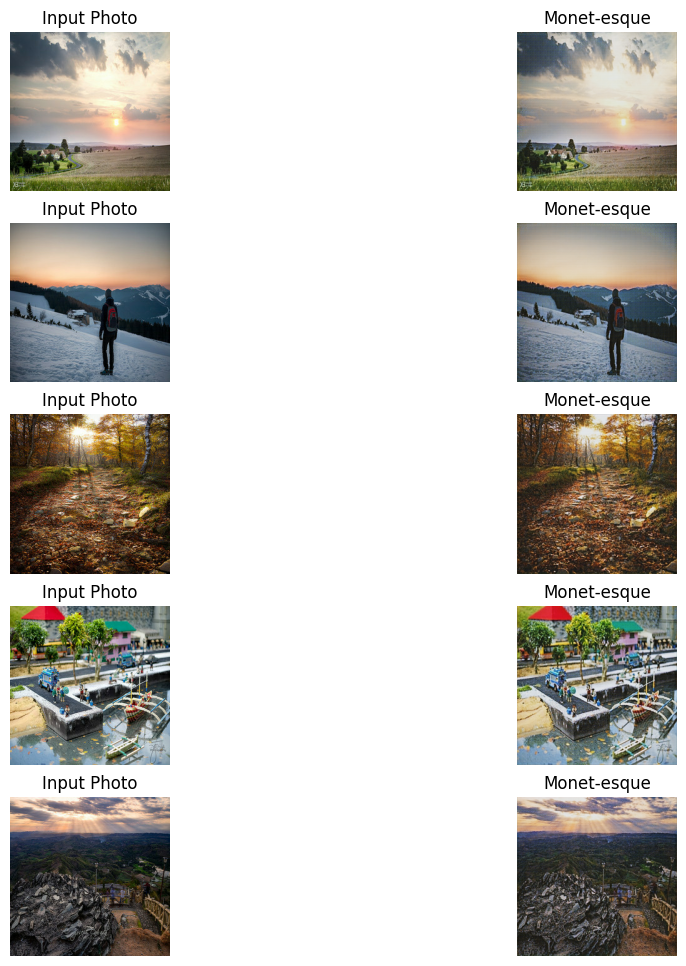

In [23]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Create submission file

In [24]:
import PIL
! mkdir ../images

mkdir: cannot create directory ‘../images’: File exists


In [25]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save(path.join(IMG_PATH, str(i) + ".jpg"))
    i += 1

In [26]:
import shutil
shutil.make_archive(ZIP_NAME, 'zip', IMG_PATH)

'/home/farzat/files/University/Colorado/courses/csca5642=introduction-to-deep-learning-boulder/notebooks/Kaggle5/images.zip'